In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"zaurasgarli","key":"dbf92ee97193244da3fc66a2d2861ca6"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mallapraveen/signature-matching

Dataset URL: https://www.kaggle.com/datasets/mallapraveen/signature-matching
License(s): CC0-1.0
signature-matching.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -q "/content/signature-matching.zip"

replace custom/data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace custom/data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
yes


In [ ]:
import os

In [ ]:
for dirpath, dirnames, filenames in os.walk('/content/custom'):
  print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

There are 1 directories and 3 images in /content/custom
There are 238 directories and 0 images in /content/custom/full
There are 0 directories and 12 images in /content/custom/full/061_forg
There are 0 directories and 24 images in /content/custom/full/107_forg
There are 0 directories and 12 images in /content/custom/full/048
There are 0 directories and 24 images in /content/custom/full/088_forg
There are 0 directories and 12 images in /content/custom/full/061
There are 0 directories and 12 images in /content/custom/full/030
There are 0 directories and 12 images in /content/custom/full/024_forg
There are 0 directories and 24 images in /content/custom/full/095_forg
There are 0 directories and 24 images in /content/custom/full/014
There are 0 directories and 12 images in /content/custom/full/018
There are 0 directories and 12 images in /content/custom/full/017
There are 0 directories and 12 images in /content/custom/full/041_forg
There are 0 directories and 24 images in /content/custom/fu

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pathlib
import random
import pandas as pd
import numpy as np

In [ ]:
train_data = pd.read_csv('/content/custom/train_data.csv')

In [ ]:
test_data = pd.read_csv('/content/custom/test_data.csv')

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76721 entries, 0 to 76720
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       76721 non-null  object
 1   1       76721 non-null  object
 2   2       76721 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.8+ MB


In [ ]:
train_data.head(7)

,0,1,2
0,100/100_22.png,100/100_20.png,1
1,078/078_17.png,078/078_13.png,1
2,089/089_17.png,089_forg/089_forg_18.png,0
3,111/111_15.png,111/111_03.png,1
4,092/092_10.png,092_forg/092_forg_05.png,0
5,090/090_10.png,090/090_18.png,1
6,035/035_07.png,035_forg/035_forg_04.png,0


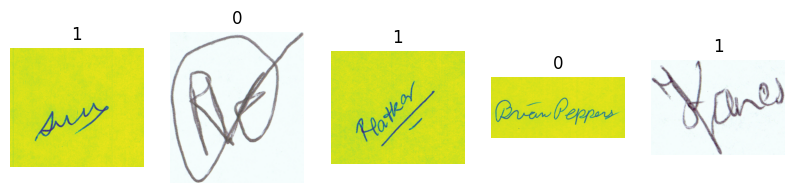

In [ ]:
plt.figure(figsize=(10, 10))
for _ in range(5):
  random_idx = random.choice(train_data.index)

  img = mpimg.imread('/content/custom/full/' + train_data.loc[random_idx, '0'])
  target_class = train_data.loc[random_idx, '2']

  plt.subplot(1, 5, _ + 1)
  plt.imshow(img)
  plt.title(target_class)
  plt.axis('off')

In [ ]:
import tensorflow as tf
import pandas as pd
import os

# Settings
IMAGE_FOLDER = "/content/custom/full"  # or your correct path
IMG_SIZE = (224, 224)

# Prepare dataset inputs
def get_image_pair_paths_and_labels(df, base_folder):
    img1_paths = df["0"].apply(lambda x: os.path.join(base_folder, x)).tolist()
    img2_paths = df["1"].apply(lambda x: os.path.join(base_folder, x)).tolist()
    labels = df["2"].astype(int).tolist()
    return list(zip(img1_paths, img2_paths)), labels

# Load and preprocess a single image
def load_image_tf(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image

# Build final tf.data.Dataset
def make_paired_dataset(pairs, labels, batch_size=32, shuffle=True):
    def generator():
        for (path1, path2), label in zip(pairs, labels):
            yield path1.encode(), path2.encode(), label

    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(), dtype=tf.string),
            tf.TensorSpec(shape=(), dtype=tf.string),
            tf.TensorSpec(shape=(), dtype=tf.int32),
        )
    )

    def process(path1, path2, label):
        img1 = load_image_tf(path1)
        img2 = load_image_tf(path2)
        return (img1, img2), label

    if shuffle:
        dataset = dataset.shuffle(buffer_size=1024)
    dataset = dataset.map(process, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache()
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


In [ ]:
train_df = train_data
train_pairs, train_labels = get_image_pair_paths_and_labels(train_df, IMAGE_FOLDER)
train_dataset = make_paired_dataset(train_pairs, train_labels)
test_df = test_data
test_pairs, test_labels = get_image_pair_paths_and_labels(test_df, IMAGE_FOLDER)
test_dataset = make_paired_dataset(test_pairs, test_labels)

# Preview a batch
for (img1_batch, img2_batch), label_batch in train_dataset.take(1):
    print("Image 1 shape:", img1_batch.shape)
    print("Image 2 shape:", img2_batch.shape)
    print("Labels:", label_batch.numpy())

steps_per_epoch = len(train_pairs) // 32

Image 1 shape: (32, 224, 224, 3)
Image 2 shape: (32, 224, 224, 3)
Labels: [1 1 1 0 1 1 0 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 1]


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_siamese_model(input_shape=(224, 224, 3)):
    # Define a small custom CNN for feature extraction
    def build_cnn(input_layer):
        x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Flatten()(x)
        x = layers.Dense(512, activation='relu')(x)
        return x

    # Inputs for both images
    input1 = layers.Input(shape=input_shape)
    input2 = layers.Input(shape=input_shape)

    # Apply CNN to both inputs
    feat1 = build_cnn(input1)
    feat2 = build_cnn(input2)

    # Compare features (L1 distance)
    merged = layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([feat1, feat2])

    # Classification
    x = layers.Dense(256, activation='relu')(merged)
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    # Final model
    model = models.Model(inputs=[input1, input2], outputs=output)
    return model

In [ ]:
def contrastive_loss(y_true, y_pred, margin=1.0):
    y_true = tf.cast(y_true, tf.float32)
    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean((1 - y_true) * square_pred + y_true * margin_square)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
model = build_siamese_model()
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss=contrastive_loss, metrics=['accuracy'])

model.fit(train_dataset, epochs=10, validation_data=test_dataset,  steps_per_epoch=steps_per_epoch, validation_steps=len(test_pairs) // 32)

Epoch 1/10
 130/2397 ━━━━━━━━━━━━━━━━━━━━ 9:32 253ms/step - accuracy: 0.5117 - loss: 0.2739